In [163]:
import sys
import importlib
sys.path.insert(1, r'C:\Users\alyahyma\Projects\NBA_API\codes')

# Import the module
from my_functions import NBA_functions
from my_functions import plotting_functions

# Reload the module (note how we pass the module object directly)
importlib.reload(NBA_functions)
importlib.reload(plotting_functions)

# Now you can use your imported functions
from my_functions.NBA_functions import team_log
from my_functions.NBA_functions import get_team_abbreviation
from my_functions.plotting_functions import set_fig_style


In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import date
import requests
import matplotlib as mpl

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from nba_api.stats.endpoints import leaguegamefinder, teamgamelog, boxscoreadvancedv2, boxscoreadvancedv3
from nba_api.stats.static import teams, players
from nba_api.live.nba.endpoints import scoreboard

import seaborn as sns


In [39]:
OKC_team_log = team_log(get_team_abbreviation('thunder'))

In [36]:
def player_season_stat(full_name = 'Kobe Bryant'):
    """
    Fetches player stat

    Parameters:
    -----------
    first_name: str
        Player first name (e.g., 'LeBron' for LeBron James).
    

    Returns:
    --------
    pd.DataFrame:
        A Pandas DataFrame containing player career stats.

    Example:
    --------
    >>> df = player_season_stat(full_name = 'Kobe Bryant')
    
    """
    nba_players = players.get_players()
    player_info = [player for player in nba_players if player['full_name'] == full_name][0]
    gamefinder = leaguegamefinder.LeagueGameFinder(player_id_nullable = player_info['id'])
    games_stats = gamefinder.get_data_frames()[0]
    
    return games_stats


In [38]:
kobe_career_stats = player_season_stat(full_name = 'Kobe Bryant')
kobe_career_stats = kobe_career_stats[(kobe_career_stats['SEASON_ID'].str[0] == '2') | \
                  (kobe_career_stats['SEASON_ID'].str[0] == '4') ]    # filter for reg and post season

kobe_reg_seasons_df = kobe_career_stats[(kobe_career_stats['SEASON_ID'].str[0] == '2')]
kobe_post_seasons_df = kobe_career_stats[(kobe_career_stats['SEASON_ID'].str[0] == '4')]

In [41]:
OKC_team_log.columns

Index(['Team_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'W', 'L', 'W_PCT',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS'],
      dtype='object')

In [46]:
OKC_team_log['home_away'] = OKC_team_log['MATCHUP'].apply(lambda x: 'home' if 'vs.' in x else 'away')


In [48]:
OKC_team_log

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,home_away
0,1610612760,0022401002,"MAR 19, 2025",OKC vs. PHI,W,57,12,0.826,240,47,...,11,44,55,36,10,5,12,12,133,home
1,1610612760,0022400982,"MAR 16, 2025",OKC @ MIL,W,56,12,0.824,240,46,...,8,42,50,30,3,3,9,20,121,away
2,1610612760,0022400969,"MAR 15, 2025",OKC @ DET,W,55,12,0.821,240,43,...,10,34,44,17,11,8,17,20,113,away
3,1610612760,0022400946,"MAR 12, 2025",OKC @ BOS,W,54,12,0.818,240,40,...,11,33,44,19,7,2,12,17,118,away
4,1610612760,0022400936,"MAR 10, 2025",OKC vs. DEN,L,53,12,0.815,240,47,...,13,24,37,29,9,6,10,16,127,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,1610612760,0022400140,"NOV 01, 2024",OKC @ POR,W,5,0,1.000,240,51,...,14,31,45,31,14,9,13,29,137,away
65,1610612760,0022400125,"OCT 30, 2024",OKC vs. SAS,W,4,0,1.000,240,41,...,5,34,39,28,18,6,10,15,105,home
66,1610612760,0022400100,"OCT 27, 2024",OKC vs. ATL,W,3,0,1.000,240,44,...,11,34,45,26,13,12,10,23,128,home
67,1610612760,0022400091,"OCT 26, 2024",OKC @ CHI,W,2,0,1.000,240,45,...,9,45,54,21,15,5,10,18,114,away


In [178]:
team_conf_info = {
    "Atlanta Hawks"         : ("East", "Southeast"),
    "Boston Celtics"        : ("East", "Atlantic"),
    "Brooklyn Nets"         : ("East", "Atlantic"),
    "Charlotte Hornets"     : ("East", "Southeast"),
    "Chicago Bulls"         : ("East", "Central"),
    "Cleveland Cavaliers"   : ("East", "Central"),
    "Dallas Mavericks"      : ("West", "Southwest"),
    "Denver Nuggets"        : ("West", "Northwest"),
    "Detroit Pistons"       : ("East", "Central"),
    "Golden State Warriors" : ("West", "Pacific"),
    "Houston Rockets"       : ("West", "Southwest"),
    "Indiana Pacers"        : ("East", "Central"),
    "LA Clippers"           : ("West", "Pacific"),
    "Los Angeles Lakers"    : ("West", "Pacific"),
    "Memphis Grizzlies"     : ("West", "Southwest"),
    "Miami Heat"            : ("East", "Southeast"),
    "Milwaukee Bucks"       : ("East", "Central"),
    "Minnesota Timberwolves": ("West", "Northwest"),
    "New Orleans Pelicans"  : ("West", "Southwest"),
    "New York Knicks"       : ("East", "Atlantic"),
    "Oklahoma City Thunder" : ("West", "Northwest"),
    "Orlando Magic"         : ("East", "Southeast"),
    "Philadelphia 76ers"    : ("East", "Atlantic"),
    "Phoenix Suns"          : ("West", "Pacific"),
    "Portland Trail Blazers": ("West", "Northwest"),
    "Sacramento Kings"      : ("West", "Pacific"),
    "San Antonio Spurs"     : ("West", "Southwest"),
    "Toronto Raptors"       : ("East", "Atlantic"),
    "Utah Jazz"             : ("West", "Northwest"),
    "Washington Wizards"    : ("East", "Southeast")
}

def clean_up_to_date_season_stats():
    
    """
    
    Fetches up to NBA season stat df, remove unnessary col such as season_ID, game_ID etc
    also add recorfs within cnf, within division, conf rank, league rank.
    
    """
    
    # Retrieve the games data for the season
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2024-25', league_id_nullable='00')
    games_df = gamefinder.get_data_frames()[0]
    
    # Filter necessary games and teams to reduce data size
    games_df = games_df[games_df['SEASON_ID'] == '22024']
    nba_teams = games_df['TEAM_NAME'].value_counts().index[:30]
    
    games_df = games_df[games_df['TEAM_NAME'].isin(nba_teams)]

        
    # Merge with team configuration data
    team_conf_df = pd.DataFrame.from_dict(team_conf_info, orient='index', columns=['team_conf', 'team_div']).reset_index()
    team_conf_df.rename(columns={'index': 'TEAM_NAME'}, inplace=True)
    games_df = games_df.merge(team_conf_df, on='TEAM_NAME', how='left')
    
    # Calculate mean statistics and win-loss percentage
    season_stats = games_df.groupby('TEAM_NAME').mean(numeric_only=True)
    season_stats.drop(['TEAM_ID', 'MIN'], axis=1, inplace=True)
    season_df = season_stats.merge(team_conf_df, on='TEAM_NAME', how='left')
    
    # Win/Loss counts and percentage
    win_loss_counts = games_df.groupby('TEAM_NAME')['WL'].value_counts().unstack(fill_value=0)
    win_loss_counts['WL_PCT'] = win_loss_counts['W'] / (win_loss_counts['W'] + win_loss_counts['L'])
    season_df = season_df.merge(win_loss_counts[['WL_PCT']], on='TEAM_NAME', how='left')
    
    # Adjust matchups and calculate win percentages against conference and division
    games_df['opponent'] = games_df['MATCHUP'].str[-3:]
    games_df['opponent_conf'] = games_df['opponent'].map(games_df.set_index("TEAM_ABBREVIATION")["team_conf"].to_dict())
    games_df['opponent_div'] = games_df['opponent'].map(games_df.set_index("TEAM_ABBREVIATION")["team_div"].to_dict())
    
    # Define function to calculate percentage
    def calculate_pct(df, group_field):
        counts = df.groupby(group_field)["WL"].value_counts().unstack(fill_value=0)
        counts['WL_PCT'] = counts['W'] / (counts['W'] + counts['L'])
        return counts[['WL_PCT']]
    
    # Merge conference and division win percentages
    conf_pct = calculate_pct(games_df[games_df['team_conf'] == games_df['opponent_conf']], 'TEAM_NAME')
    div_pct = calculate_pct(games_df[games_df['team_div'] == games_df['opponent_div']], 'TEAM_NAME')
    season_df = season_df.merge(conf_pct, on='TEAM_NAME', how='left', suffixes=('', '_conf'))
    season_df = season_df.merge(div_pct, on='TEAM_NAME', how='left', suffixes=('', '_div'))
    
    # Home and away win percentages
    games_df['home_away'] = games_df['MATCHUP'].apply(lambda x: 'home' if 'vs.' in x else 'away')
    home_pct = calculate_pct(games_df[games_df['home_away'] == 'home'], 'TEAM_NAME')
    away_pct = calculate_pct(games_df[games_df['home_away'] == 'away'], 'TEAM_NAME')
    season_df = season_df.merge(home_pct, on='TEAM_NAME', how='left', suffixes=('', '_home'))
    season_df = season_df.merge(away_pct, on='TEAM_NAME', how='left', suffixes=('', '_away'))
    
    # Calculate standings
    season_df['league_standing'] = season_df['WL_PCT'].rank(method='dense', ascending=False).astype(int)
    season_df['conference_standing'] = season_df.groupby('team_conf')['WL_PCT_conf'].rank(method='dense', ascending=False).astype(int)
    
    return season_df, games_df

season_df,games_df = clean_up_to_date_season_stats()
season_df ['WL_cat'] = season_df['WL_PCT'].apply(lambda x: 'above .500' if x>0.5 else 'below .500')
win_loss_counts = games_df.groupby('TEAM_NAME')['WL'].value_counts().unstack(fill_value=0)
season_df = season_df.merge(win_loss_counts[['W']], on='TEAM_NAME', how='left')

In [129]:
import numpy as np

def simulate_season(current_standings, simulations=10000, remaining_games=13):
    """
    Simulate the remaining season and calculate the probability of each team
    maintaining their current rank, including consideration of games back.

    Parameters:
        current_standings (dict): Dictionary with team names as keys and tuples (win_rate, current_rank, total_wins) as values.
        simulations (int): Number of simulations to run.
        remaining_games (int): Number of games each team still has to play.

    Returns:
        dict: A dictionary with team names as keys and the probability of maintaining current rank as values.
    """
    teams = list(current_standings.keys())
    num_teams = len(teams)
    final_positions = {team: [] for team in teams}

    # Array to hold the results of all simulations for all teams
    season_results = np.zeros((simulations, num_teams))

    # Simulate the results of the remaining games for each team
    for i, (team, (win_rate, _, total_wins)) in enumerate(current_standings.items()):
        wins = np.sum(np.random.rand(simulations, remaining_games) < win_rate, axis=1)
        season_results[:, i] = wins + total_wins

    # Determine ranks and games back in each simulation
    for simulation in range(simulations):
        # Get ranks based on wins
        ordered_indices = np.argsort(-season_results[simulation, :])
        sorted_teams = np.array(teams)[ordered_indices]
        sorted_wins = season_results[simulation, ordered_indices]

        # Calculate games back for each team
        games_back = sorted_wins[0] - sorted_wins  # Games back from the top team

        for rank, team_index in enumerate(ordered_indices):
            final_positions[teams[team_index]].append(rank + 1)

    # Calculate probability of each team maintaining its current rank
    rank_probabilities = {}
    for team in teams:
        current_rank = current_standings[team][1]
        rank_counts = final_positions[team]
        rank_probabilities[team] = rank_counts.count(current_rank) / simulations

    return rank_probabilities



In [194]:
# Assuming season_df is already defined with 'TEAM_NAME' and 'WL_PCT'
def create_standings_dict(season_df):
    # Sort the DataFrame by win percentage in descending order to rank teams
    season_df = season_df.sort_values('WL_PCT', ascending=False).reset_index(drop=True)
    # Add a 'RANK' column that denotes the ranking of each team
    season_df['RANK'] = season_df.index + 1
    
    # Create the dictionary from the DataFrame
    current_standings = {
        row['TEAM_NAME']: (row['WL_PCT'], row['RANK'],row['W'])
        for _, row in season_df.iterrows()
    }
    
    return current_standings


standings_dict = create_standings_dict(season_df[season_df['team_conf']=='West'])
simulate_season(standings_dict, simulations=10000, remaining_games=13)

{'Oklahoma City Thunder': 1.0,
 'Houston Rockets': 0.6593,
 'Denver Nuggets': 0.4255,
 'Los Angeles Lakers': 0.3591,
 'Memphis Grizzlies': 0.376,
 'Golden State Warriors': 0.4965,
 'LA Clippers': 0.3439,
 'Minnesota Timberwolves': 0.3788,
 'Sacramento Kings': 0.7655,
 'Dallas Mavericks': 0.446,
 'Phoenix Suns': 0.4424,
 'Portland Trail Blazers': 0.654,
 'San Antonio Spurs': 0.8424,
 'New Orleans Pelicans': 0.9678,
 'Utah Jazz': 0.9678}

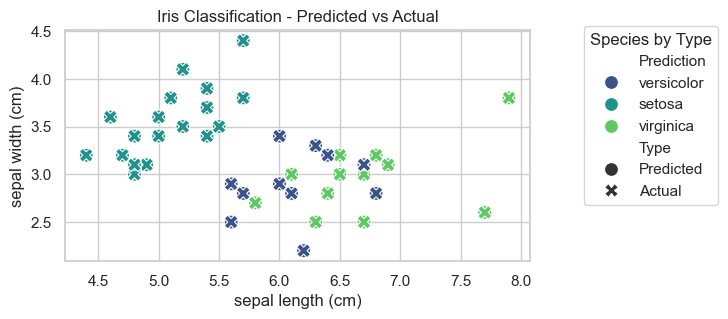

Accuracy: 1.0


In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data
iris = load_iris()
X = iris.data
y = iris.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Prepare DataFrame for plotting
test_data = pd.DataFrame(X_test, columns=iris.feature_names)
test_data['Species'] = [iris.target_names[i] for i in y_test]
test_data['Prediction'] = [iris.target_names[i] for i in y_pred]
test_data['Type'] = 'Predicted'  # Mark these rows as predicted

# Create a similar DataFrame for actual data
actual_data = pd.DataFrame(X_test, columns=iris.feature_names)
actual_data['Species'] = [iris.target_names[i] for i in y_test]
actual_data['Prediction'] = [iris.target_names[i] for i in y_test]  # Use true labels for both
actual_data['Type'] = 'Actual'  # Mark these rows as actual

# Concatenate the actual and predicted for plotting purposes
plot_data = pd.concat([test_data, actual_data])

# Plot using seaborn
plt.figure(figsize=(6, 3))
sns.scatterplot(data=plot_data, x=iris.feature_names[0], y=iris.feature_names[1], hue='Prediction', style='Type', palette='viridis', s=100)
plt.title('Iris Classification - Predicted vs Actual')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(title='Species by Type',bbox_to_anchor=(1.1, 1.05))
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.00


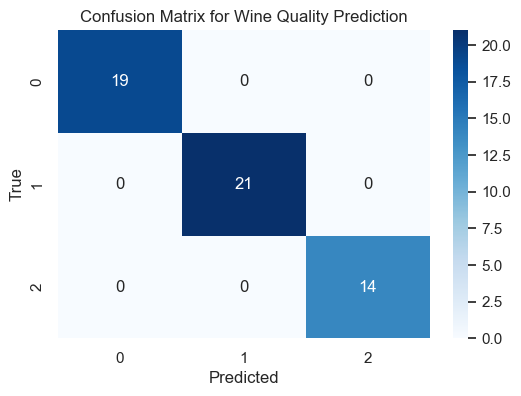

In [245]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Wine dataset
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Quality'] = data.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Quality']), df['Quality'], test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(df['Quality']), yticklabels=np.unique(df['Quality']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Wine Quality Prediction')
plt.show()


Mean Squared Error: 0.26
R2 Score: 0.80


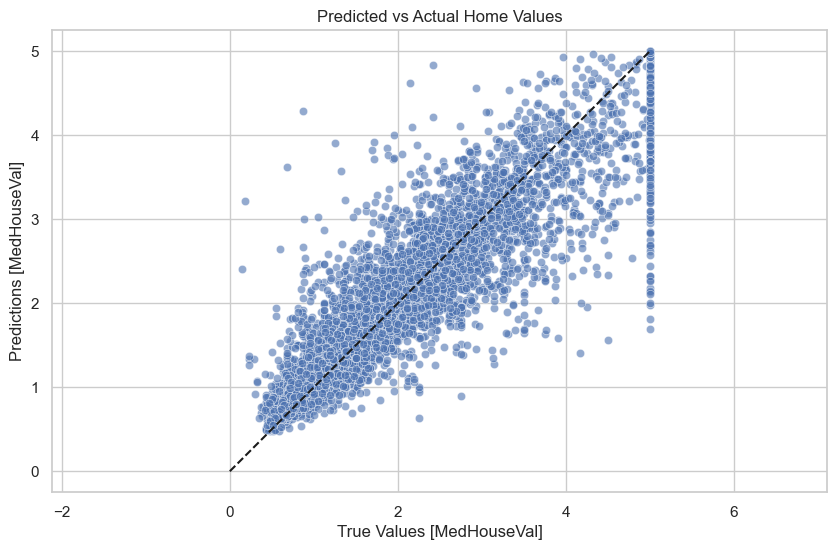

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load the California Housing dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target  # Median House Value

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['MedHouseVal']), df['MedHouseVal'], test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test_scaled)

# Calculate and print the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plotting predicted vs actual values using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, 5], [0, 5], '--k')  # Add a line of perfect prediction for reference
plt.xlabel('True Values [MedHouseVal]')
plt.ylabel('Predictions [MedHouseVal]')
plt.title('Predicted vs Actual Home Values')
plt.axis('equal')
plt.show()


Mean Squared Error: 98.69
R2 Score: 0.37


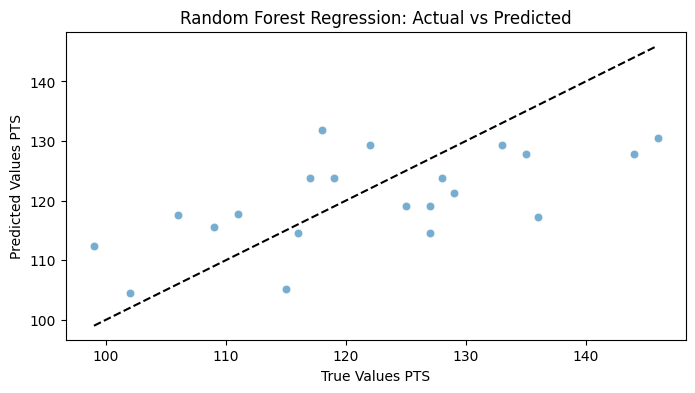

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming season_df is already defined

df = games_df[games_df['TEAM_ABBREVIATION'] == 'OKC'].copy()

# Define target and features
target = 'PTS'  # Single column as a string
features = ['AST']  # List of feature columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test_scaled)

# Convert y_pred to a DataFrame for easier handling
y_test = y_test.reset_index(drop=True)  # Ensure y_test is a 1D Series
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  # Create a DataFrame for plotting

# Calculate and print the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plot using seaborn
plt.figure(figsize=(8, 4))
sns.scatterplot(data=plot_df, x='Actual', y='Predicted', alpha=0.6)
plt.plot([plot_df.min().min(), plot_df.max().max()], [plot_df.min().min(), plot_df.max().max()], '--k')  # Perfect prediction line
plt.xlabel(f"True Values {target}")
plt.ylabel(f"Predicted Values {target}")
plt.title("Random Forest Regression: Actual vs Predicted")
plt.show()


In [89]:
games_df['points_allowed'] = games_df.apply(lambda row: row['PTS'] - row['PLUS_MINUS'] if row['PLUS_MINUS'] > 0 
                                            else row['PTS'] + abs(row['PLUS_MINUS']), axis=1)
games_df[['PTS','PLUS_MINUS','points_allowed']]

games_df ['WL_binary'] = games_df['WL'].apply(lambda x: 1 if x == 'W' else 0)
games_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,PF,PLUS_MINUS,team_conf,team_div,opponent,opponent_conf,opponent_div,home_away,points_allowed,WL_binary
0,22024,1610612741,CHI,Chicago Bulls,0022401013,2025-03-20,CHI @ SAC,W,239,128,...,19,12.0,East,Central,SAC,West,Pacific,away,116.0,1
1,22024,1610612747,LAL,Los Angeles Lakers,0022400996,2025-03-20,LAL vs. MIL,L,239,89,...,25,-29.0,West,Pacific,MIL,East,Central,home,118.0,0
2,22024,1610612766,CHA,Charlotte Hornets,0022401010,2025-03-20,CHA vs. NYK,W,239,115,...,20,17.0,East,Southeast,NYK,East,Atlantic,home,98.0,1
3,22024,1610612754,IND,Indiana Pacers,0022401011,2025-03-20,IND vs. BKN,W,265,105,...,21,6.0,East,Central,BKN,East,Atlantic,home,99.0,1
4,22024,1610612752,NYK,New York Knicks,0022401010,2025-03-20,NYK @ CHA,L,240,98,...,18,-17.0,East,Atlantic,CHA,East,Southeast,away,115.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,22024,1610612737,ATL,Atlanta Hawks,0022400064,2024-10-23,ATL vs. BKN,W,241,120,...,20,4.0,East,Southeast,BKN,East,Atlantic,home,116.0,1
2080,22024,1610612752,NYK,New York Knicks,0022400061,2024-10-22,NYK @ BOS,L,241,109,...,12,-23.0,East,Atlantic,BOS,East,Atlantic,away,132.0,0
2081,22024,1610612750,MIN,Minnesota Timberwolves,0022400062,2024-10-22,MIN @ LAL,L,239,103,...,22,-7.0,West,Northwest,LAL,West,Pacific,away,110.0,0
2082,22024,1610612738,BOS,Boston Celtics,0022400061,2024-10-22,BOS vs. NYK,W,240,132,...,15,23.0,East,Atlantic,NYK,East,Atlantic,home,109.0,1


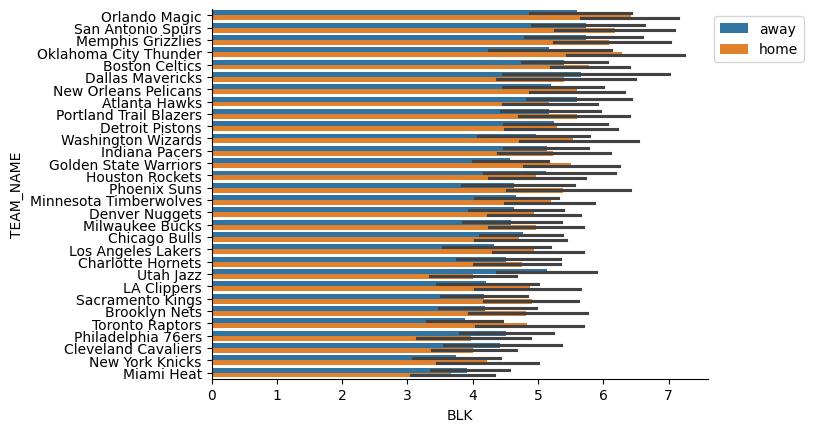

In [78]:
# what a nice simple descriptive plot! inteestingly the difference betwee home and away is just a trend
plot_df = games_df.groupby(['TEAM_NAME','home_away']).mean(numeric_only=True)[['PTS','PLUS_MINUS','points_allowed']]
plot_df = plot_df.reset_index()  # Reset index so 'TEAM_NAME' and 'home_away' are columns

order_df = games_df.groupby('TEAM_NAME')['BLK'].mean().sort_values(ascending=False).index

sns.barplot(data=games_df, x='BLK', y='TEAM_NAME', hue='home_away', errorbar='ci', estimator=np.mean, order = order_df)  

sns.despine()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

correlation between 3 points % and winning: 0.3457810496693195, pval = 1.3566014138758548e-59
correlation between 3 points attempt and winning: 0.0386989215934833, pval = 0.07735554559555814


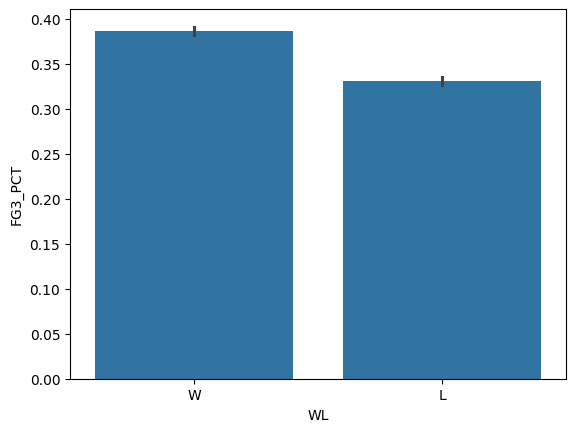

In [120]:
# Objective: Determine how three-point shooting (both in terms of attempts and efficiency) correlates with winning games.
# Steps:
# Calculate Metrics:
# Compute the average number of three-point attempts (FG3A) and three-point percentage (FG3_PCT) for each team, both in wins and losses.
# Correlation Analysis:
plot_df = games_df.groupby(['TEAM_NAME','WL']).mean(numeric_only=True)[['FG3A','FG3_PCT','FG3M']]
order_df = games_df.groupby('TEAM_NAME')['FG3_PCT'].mean().sort_values(ascending=False).index


# Analyze the correlation between three-point attempts (FG3A), three-point percentage (FG3_PCT), 
#and winning (WL where 'W' is a win and 'L' is a loss). You might consider converting 'WL' into a binary variable
#(1 for win, 0 for loss) for this analysis.
games_df ['WL_binary'] = games_df['WL'].apply(lambda x: 1 if x == 'W' else 0)
correlation_between_FG3PCT_win = games_df['FG3_PCT'].corr(games_df['WL_binary'])
correlation_between_FG3A_win   = games_df['FG3A'].corr(games_df['WL_binary'])

from scipy import stats
_,p_val_for_FG3PCT_corr = stats.pearsonr(games_df['WL_binary'],games_df['FG3_PCT'])
_,p_val_for_FG3A_corr   = stats.pearsonr(games_df['WL_binary'],games_df['FG3A'])

print(f'correlation between 3 points % and winning: {correlation_between_FG3PCT_win}, pval = {p_val_for_FG3PCT_corr}')
print(f'correlation between 3 points attempt and winning: {correlation_between_FG3A_win}, pval = {p_val_for_FG3A_corr}')

# Visual Representation:
# Create scatter plots to visualize the relationship between the number of three-point attempts, the three-point shooting percentage, and winning games.
sns.barplot(data = games_df,x = 'WL', y = 'FG3_PCT', errorbar = 'ci')
plt.show()
# Advanced Analysis (Optional):
# Use a logistic regression model to quantitatively assess how much three-point attempts and shooting percentages affect the likelihood of winning.


In [121]:
def NBA_games_logistic_regression(df: pd.DataFrame = games_df, team_abbreviation: str = 'BOS',
                                  predictors: list = ['FGA', 'FGM'], response: str = 'WL'):
    """
    Performs logistic regression on NBA games data to classify the response variable based on given predictors.

    Parameters:
    df (pd.DataFrame): DataFrame containing NBA games data with required columns.
    team_abbreviation (str): Abbreviation of the team for which the model is to be fitted.
    predictors (list): List of column names in df to be used as predictors in the model.
    response (str): The column name in df which is to be used as the binary response variable (e.g., 'WIN_LOSE' column with values 0 for loss and 1 for win).

    Returns:
    tuple: A tuple containing three elements:
        - pd.DataFrame: A DataFrame with actual and predicted values of the response variable along with one of the predictors for plotting.
        - float: Accuracy of the model.
        - pd.DataFrame: Confusion matrix of the model predictions.

    Raises:
    TypeError: If 'df' is not a pandas DataFrame, or 'team_abbreviation', 'predictors', or 'response' are not of expected type.
    ValueError: If 'team_abbreviation' not in DataFrame, or 'predictors' or 'response' columns are not in DataFrame.
                 If any of the predictor or response columns contain non-numeric data.
                 If the response column is not binary.
    """

    # Validate input types
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected 'df' to be a pandas DataFrame.")
    if not isinstance(team_abbreviation, str):
        raise TypeError("Expected 'team_abbreviation' to be a string.")
    if not isinstance(predictors, list) or not all(isinstance(item, str) for item in predictors):
        raise TypeError("Expected 'predictors' to be a list of strings.")
    if not isinstance(response, str):
        raise TypeError("Expected 'response' to be a string.")

    # Validate input values
    if team_abbreviation not in df['TEAM_ABBREVIATION'].unique():
        raise ValueError(f"Team abbreviation '{team_abbreviation}' not found in DataFrame.")
    if any(col not in df.columns for col in predictors):
        raise ValueError("Some predictors are not present in DataFrame.")
    if response not in df.columns:
        raise ValueError(f"Response column '{response}' is not present in DataFrame.")

    # Check if columns are numeric
    for col in predictors:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Predictor column '{col}' must be numeric for logistic regression.")

    if df[response].nunique() != 2:
        raise ValueError(f"Response column '{response}' must be binary (contain exactly two unique values).")

    # Proceed with the logistic regression analysis
    X = df[df['TEAM_ABBREVIATION'] == team_abbreviation][predictors].values
    y = df[df['TEAM_ABBREVIATION'] == team_abbreviation][response].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Create and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Prepare the DataFrame for visualization
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Prepare confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    return results_df, accuracy, pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])


model accuracy: 0.6458733205374281


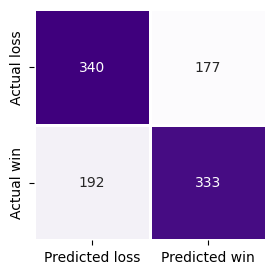

In [156]:
X = games_df['FG3_PCT'].values
y = games_df['WL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = LogisticRegression()
model.fit(X_train.reshape(-1, 1), y_train)

y_pred = model.predict(X_test.reshape(-1,1))

accuracy = accuracy_score(y_test, y_pred)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

conf_matrix = confusion_matrix(y_test, y_pred)

print(f'model accuracy: {accuracy}')
conf_matrix = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])


conf_matrix = conf_matrix.rename(index = {'Actual 0' : 'Actual loss','Actual 1' : 'Actual win'})
conf_matrix = conf_matrix.rename(columns = {'Predicted 0' : 'Predicted loss','Predicted 1' : 'Predicted win'})

plt.figure(figsize=(3, 3))

sns.heatmap(data=conf_matrix, annot=True, fmt='d', cmap='Purples',linewidth = 1.0, cbar = False)
plt.show()

In [157]:
# Challenge: Analyze Player Impact on Game Outcomes
# Objective: Determine the impact of key players on their team's performance in terms of game outcomes.

# Steps:

# Data Preparation:
# Identify the top players for each team based on scoring (e.g., using PTS) or other significant statistics like assists or rebounds.
# Ensure you have player-specific data available in your dataset. If not, you might need to merge your game dataset with player statistics.

# Calculate Player Metrics:
# For each identified key player, compute their average points, assists, rebounds, 
# and other relevant metrics per game. Consider both games won and lost.

# Correlation Analysis:
# Analyze how the performances of these key players correlate with game outcomes (win/loss). You could look at correlation coefficients or more advanced statistics like logistic regression to see if and how their performance metrics predict game results.

# Visualization:
# Create visualizations such as scatter plots or bar charts to show the relationship between player performance metrics and team success. This could include plotting average points per game against win percentage for each player.

# Advanced Analysis (Optional):
# Perform a regression analysis with player stats as independent variables and the game outcome as the dependent variable. 
# This could help quantify the extent to which specific player performances influence game outcomes.
# This challenge will help you explore the influence of individual players on game results, 
# offering insights that could be useful for team management, betting analyses, or fan discussions.



In [403]:
season_games_id = games_df[games_df['TEAM_ABBREVIATION']=='DEN']['GAME_ID']

season_games_advanced_stats = pd.DataFrame()

for index, game_id in enumerate(season_games_id):
    box_score = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id=season_games_id.iloc[index])
    players_game_stats = box_score.get_data_frames()[0] 
    season_games_advanced_stats = pd.concat([season_games_advanced_stats, players_game_stats], ignore_index=True)







In [ ]:
season_games_id = games_df[games_df['TEAM_ABBREVIATION']=='OKC']['GAME_ID']

season_games_advanced_stats = pd.DataFrame()

for index, game_id in enumerate(season_games_id):
    box_score = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id=season_games_id.iloc[index])
    players_game_stats = box_score.get_data_frames()[0] 
    season_games_advanced_stats = pd.concat([season_games_advanced_stats, players_game_stats], ignore_index=True)
    
season_games_id = games_df[games_df['TEAM_ABBREVIATION']=='OKC']['GAME_ID']

season_games_advanced_stats = pd.DataFrame()

for index, game_id in enumerate(season_games_id):
    box_score = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id=season_games_id.iloc[index])
    players_game_stats = box_score.get_data_frames()[0] 
    season_games_advanced_stats = pd.concat([season_games_advanced_stats, players_game_stats], ignore_index=True)

season_games_advanced_stats['player_name'] = season_games_advanced_stats['firstName'] + ' ' +  season_games_advanced_stats['familyName']

team_filt = season_games_advanced_stats[season_games_advanced_stats['teamTricode'] == 'DEN']

ratings_filt = team_filt[['player_name','gameId','comment','PIE']]                                       

ratings_filt_groupby_by_player = ratings_filt.groupby(['player_name']).mean(numeric_only=True).reset_index()

ratings_sorted = ratings_filt_groupby_by_player.sort_values(by ='PIE', ascending = False).reset_index()

player_highest_season_PIE = ratings_sorted['player_name'][0]

star_game_PIE = team_filt[team_filt['player_name'] == player_highest_season_PIE]

star_game_PIE = star_game_PIE[['gameId','PIE','player_name','comment']]
star_game_PIE = star_game_PIE.rename(columns={'gameId':'GAME_ID','PIE':'star1_PIE','comment':'played?'})

games_df_OKC = games_df[games_df['TEAM_ABBREVIATION']=='OKC']
games_df_OKC_w_star = games_df_DEN.merge(star_game_PIE, on = 'GAME_ID',how = 'left')
games_df_OKC_w_star['played?'] = games_df_DEN_w_star['played?'].apply(lambda x: False if pd.isna(x) else True)

data_path = r'C:\Users\alyahyma\Projects\NBA_API\data\games_df_OKC_w_star.pkl'
games_df_OKC_w_star.to_pickle(data_path)